---
### Closed-Form Solution with Michaelis-Menten Kinetics

Solve for lambda and Y with built-in Python library

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1, a2 = 23.8, 1.4
k1, k2 = 0.01, 0.003
N = 200

# b_min, b_max, b_large = 1e-4, 1e4, False
b_min, b_max, b_large = 5e-6, 1e-4, False
# b_min, b_max, b_large = 5e7, 1e8, True

b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

# Approximate Theory
A = np.sqrt(k1/a1)+np.sqrt(k2/a2)
B = k1/a1 + k2/a2
C = (k1/a1)**(3/2) + (k2/a2)**(3/2)
D = (k1/a1)**2 + (k2/a2)**2
E = np.sqrt((k1*k2) / (a1*a2))
F = 1/a1 + 1/a2

### Softmax transformation

In [23]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# System
def BioSystemMM3(theta, b_val):
    term_Y1 = (a1 * theta[1]) / (b_val * theta[0]) + k1 - 1
    Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
    term_Y2 = (a2 * theta[2]) / (b_val * theta[0]) + k2 - (1 - Y1)
    Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
    Y3 = (a2 * theta[2] / b_val) * (Y2 / (k2 + Y2))
    Y4 = (a2 * theta[1] * theta[2] / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    Y5 = (a2 * theta[2]**2 / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    lambda_val = b_val * Y3
    r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
    r_avg = 1 / r_denom if r_denom != 0 else np.nan
    return np.array([b_val, theta[0], theta[1], theta[2], Y1, Y2, Y3, Y4, Y5, lambda_val, r_avg])

def objective_softmax(u, b_val): return -BioSystemMM3(softmax_partition(u), b_val)[9]   # objective function

# Optimization
def optimize_for_b_softmax(b_val, tol=1e-7, gtol=1e-8, maxiter=1000):
    if b_large:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            bounds=[(-10, 10)],
            method='L-BFGS-B',   # L-BFGS-B has bounds
            tol=tol,
            options={
                'gtol': gtol,
                'maxiter': maxiter,
                'disp': False
            }
        )
    else:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            method='Powell',
            tol=tol,                       # global tolerance
            options={
                'gtol': gtol,              # gradient tolerance
                'maxiter': maxiter,        # maximum iterations
                'disp': False               # display output: True
            }
        )
        if result.success: return BioSystemMM3(softmax_partition(result.x), b_val)

# Replacing BioSystemMM3(theta1, theta2. theta3, b_val) with BioSystemMM3(array, b_val) increased
# performance by more than threefold! (2s -> 0.6 s) 20250924

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

(b_arr, theta1_arr, theta2_arr, theta3_arr, 
 Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, 
 lambda_arr, r_avg_arr) = results.T   # The "Pythonic" way using tuple unpacking!

Optimization completed in 0.71 seconds.


### Line fitting

In [24]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
Y5_lambda_fit = linear_fit(Y5_arr, lambda_arr)

### Plot the result

,Nutrient level,Growth rate,Y1,Y2,Y3,Y4,Y5,Sum_Y,Approx. Sum_Y
0,0.000005,0.000005,0.000046,0.000103,0.999698,0.000046,0.000107,1.0,None
1,0.000005,0.000005,0.000046,0.000104,0.999695,0.000046,0.000108,1.0,None
2,0.000005,0.000005,0.000047,0.000105,0.999693,0.000047,0.000109,1.0,None
3,0.000005,0.000005,0.000047,0.000106,0.999691,0.000047,0.000110,1.0,None
4,0.000005,0.000005,0.000047,0.000107,0.999688,0.000047,0.000110,1.0,None
...,...,...,...,...,...,...,...,...,...
195,0.000094,0.000094,0.000199,0.000449,0.998634,0.000203,0.000516,1.0,None
196,0.000096,0.000095,0.000200,0.000452,0.998623,0.000204,0.000520,1.0,None
197,0.000097,0.000097,0.000202,0.000456,0.998612,0.000206,0.000525,1.0,None
198,0.000099,0.000098,0.000203,0.000459,0.998601,0.000207,0.000529,1.0,None


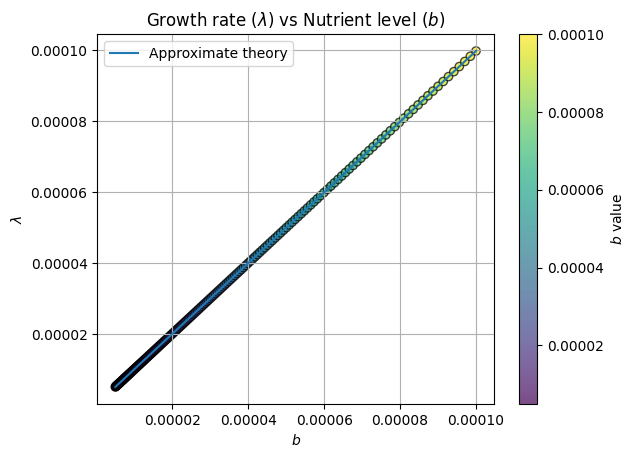

C:\Users\huang\AppData\Local\Temp\ipykernel_3092\159448486.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


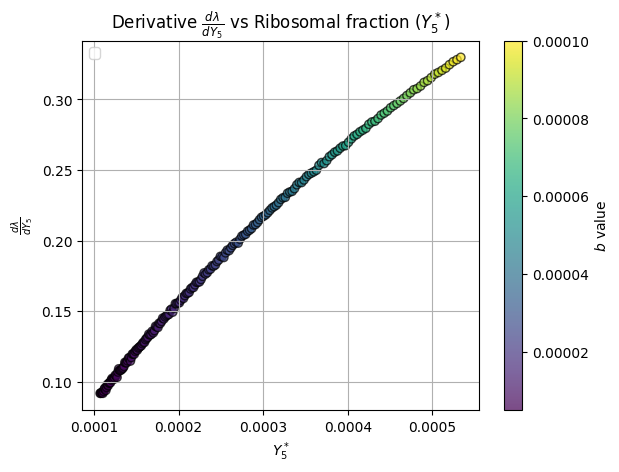

C:\Users\huang\AppData\Local\Temp\ipykernel_3092\159448486.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


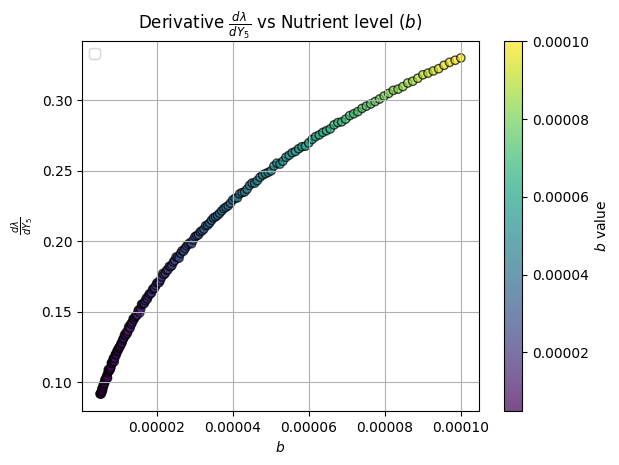

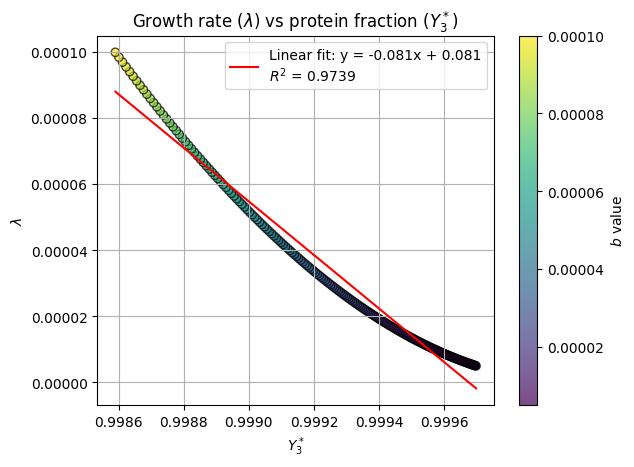

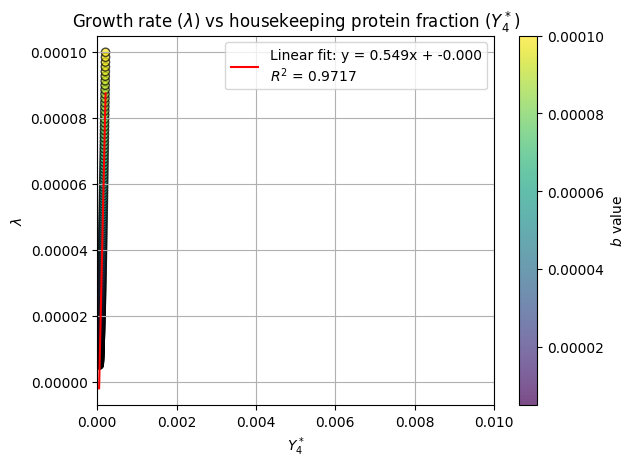

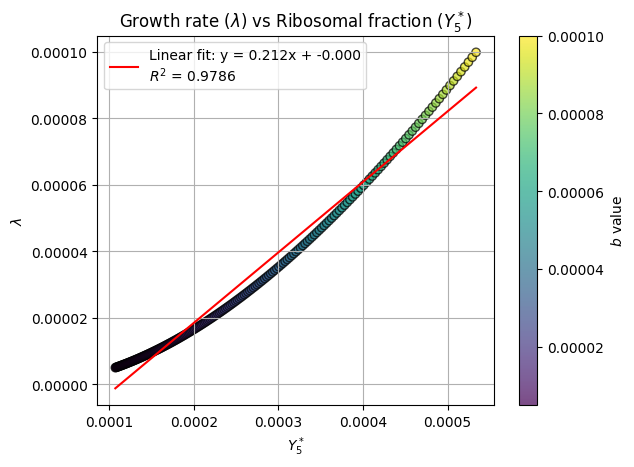

In [25]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr, 
    "Approx. Sum_Y": None
})
display(df)

# Growth rate to nutrient level (b)
if b_large:
    # A = np.sqrt(k1/a1) + np.sqrt(k2/a2)
    # not yet calculated
    pass
else:
    # A = np.sqrt(k1/a1) + np.sqrt(k2/a2)
    # B = (k1/a1) + (k2/a2)
    # F = (1/a1) + (1/a2)
    lambda_approx_arr = b_arr - 2*A*b_arr**(3/2) - ((5/2)*A**2 + (1/2)*B - F)*b_arr**2

# Calculate derivative d(lambda)/dY5
# Since lambda = b * Y3, we need d(lambda)/dY5
# Use numerical differentiation
dlambda_dY5_arr = np.gradient(lambda_arr, Y5_arr)

# Growth rate to nutrient quality (b)
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(b_arr, lambda_approx_arr, '-', label='Approximate theory')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Derivative d(lambda)/dY5 vs Y5
plt.figure()
scatter = plt.scatter(Y5_arr, dlambda_dY5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_5^*$'); plt.ylabel(r'$\frac{d\lambda}{dY_5}$')
plt.title(r'Derivative $\frac{d\lambda}{dY_5}$ vs Ribosomal fraction ($Y_5^*$)')
plt.legend()
plt.grid(True)
plt.show()

# Derivative d(lambda)/dY5 vs b
plt.figure()
scatter = plt.scatter(b_arr, dlambda_dY5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$\frac{d\lambda}{dY_5}$')
plt.title(r'Derivative $\frac{d\lambda}{dY_5}$ vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y3_lambda_fit[0], Y3_lambda_fit[1], '-', label=f'Linear fit: y = {Y3_lambda_fit[3]:.3f}x + {Y3_lambda_fit[4]:.3f}\n$R^2$ = {Y3_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y4_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y4_lambda_fit[0], Y4_lambda_fit[1], '-', label=f'Linear fit: y = {Y4_lambda_fit[3]:.3f}x + {Y4_lambda_fit[4]:.3f}\n$R^2$ = {Y4_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_4^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_4^*$)')
plt.grid(True)
plt.xlim(0, 0.01)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5)
plt.figure()
scatter = plt.scatter(Y5_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y5_lambda_fit[0], Y5_lambda_fit[1], '-', 
label=f'Linear fit: y = {Y5_lambda_fit[3]:.3f}x + {Y5_lambda_fit[4]:.3f}\n$R^2$ = {Y5_lambda_fit[2]:.4f}', color='red')
plt.xlabel(r'$Y_5^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

Data saved to PP3_MM_output.csv (200 rows)
Excel output requires openpyxl package. Install with: pip install openpyxl


,Nutrient level,Growth rate,$Y_1,$Y_2,$Y_3,$Y_4,$Y_5,Sum_Y,$\theta_1$,$\theta_2$,$\theta_3$,$p = \frac{\theta_2}{\theta_1}$,$q = \frac{\theta_3}{\theta_1}$,$\sum \theta$,Approx. $\sum \theta$
0,0.000005,0.000005,0.000046,0.000103,0.999698,0.000046,0.000107,1.0,0.999847,0.000046,0.000107,0.000046,0.000107,1.0,1.0
1,0.000005,0.000005,0.000046,0.000104,0.999695,0.000046,0.000108,1.0,0.999846,0.000046,0.000108,0.000046,0.000108,1.0,1.0
2,0.000005,0.000005,0.000047,0.000105,0.999693,0.000047,0.000109,1.0,0.999845,0.000047,0.000109,0.000047,0.000109,1.0,1.0
3,0.000005,0.000005,0.000047,0.000106,0.999691,0.000047,0.000110,1.0,0.999843,0.000047,0.000110,0.000047,0.000110,1.0,1.0
4,0.000005,0.000005,0.000047,0.000107,0.999688,0.000047,0.000110,1.0,0.999842,0.000047,0.000110,0.000047,0.000110,1.0,1.0
5,0.000005,0.000005,0.000048,0.000107,0.999686,0.000048,0.000111,1.0,0.999841,0.000048,0.000111,0.000048,0.000111,1.0,1.0
6,0.000005,0.000005,0.000048,0.000108,0.999683,0.000048,0.000112,1.0,0.999840,0.000048,0.000112,0.000048,0.000112,1.0,1.0
7,0.000006,0.000006,0.000048,0.000109,0.999681,0.000049,0.000113,1.0,0.999838,0.000049,0.000113,0.000049,0.000113,1.0,1.0
8,0.000006,0.000006,0.000049,0.000110,0.999679,0.000049,0.000114,1.0,0.999837,0.000049,0.000114,0.000049,0.000114,1.0,1.0
9,0.000006,0.000006,0.000049,0.000111,0.999676,0.000049,0.000115,1.0,0.999836,0.000049,0.000115,0.000049,0.000115,1.0,1.0


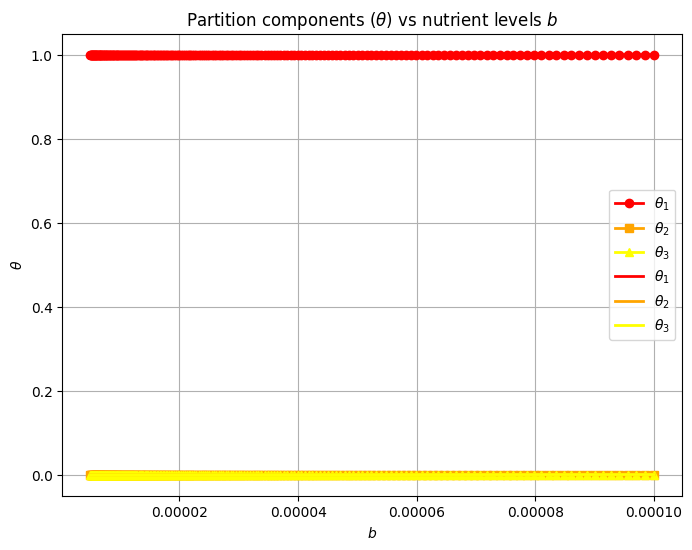

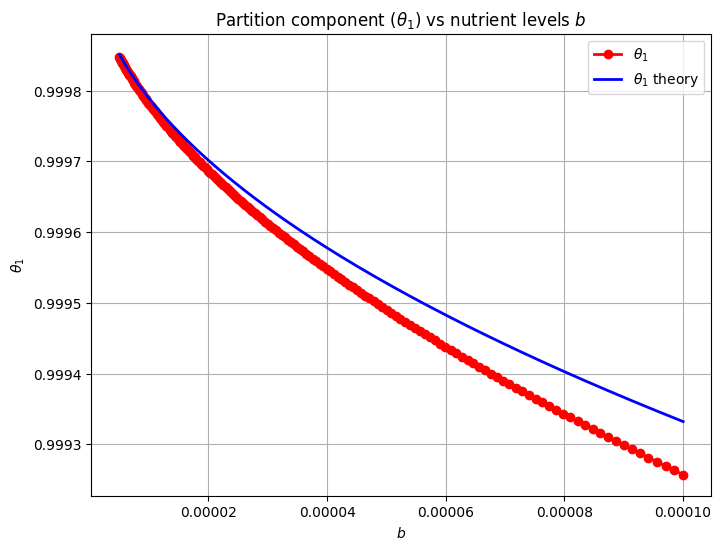

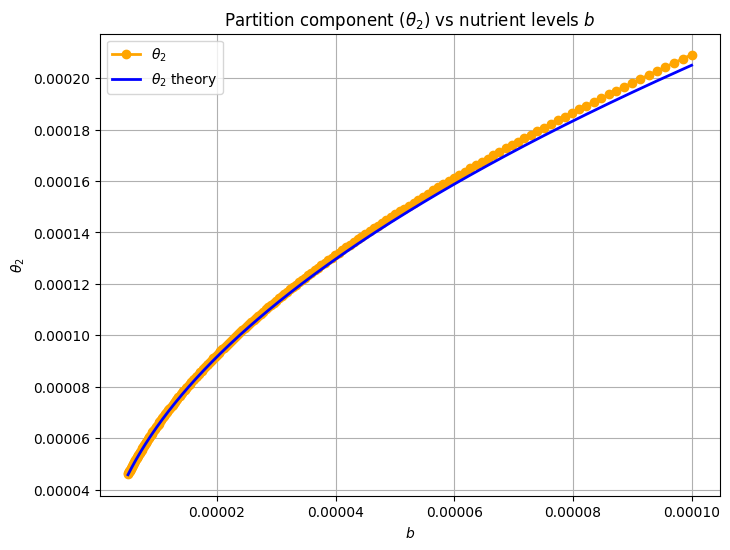

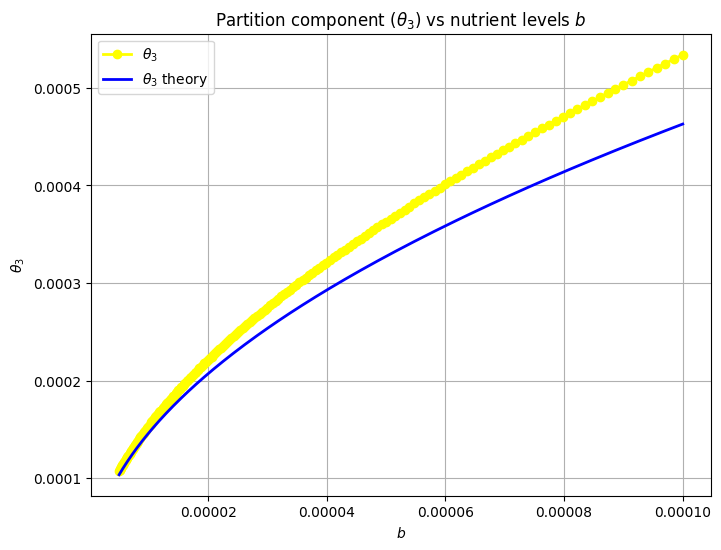

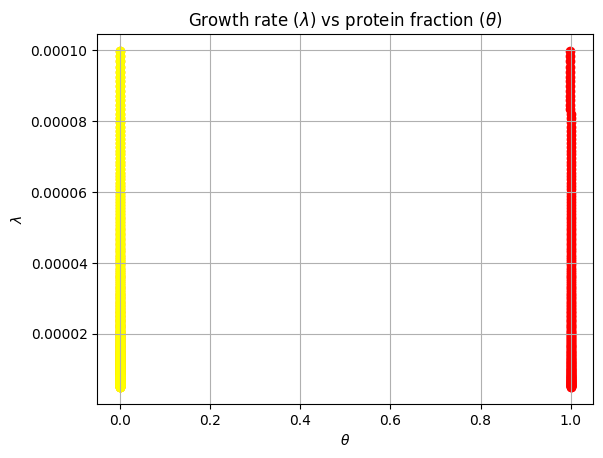

In [26]:
# Approximate Theory
# A = np.sqrt(k1/a1)+np.sqrt(k2/a2)
# B = k1/a1 + k2/a2
# C = a1/k1 + a2/k2
# D = np.sqrt((k1*k2) / (a1*a2))
# E = 1/a1 + 1/a2

if b_large:
    # not yet calculated
    pass
else:
    theta1_approx_arr = 1 - A*np.sqrt(b_arr) + (1/2)*A**3*b_arr**(3/2) - (3/8)*A**5*b_arr**(5/2)
    theta2_approx_arr = np.sqrt(k1/a1)*( np.sqrt(b_arr) - (1/2)*A**2*b_arr**(3/2) + (3/8)*A**4*b_arr**(5/2) )
    theta3_approx_arr = np.sqrt(k2/a2)*( np.sqrt(b_arr) - (1/2)*A**2*b_arr**(3/2) + (3/8)*A**4*b_arr**(5/2) )

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    r"$Y_1": Y1_arr,
    r"$Y_2": Y2_arr,
    r"$Y_3": Y3_arr,
    r"$Y_4": Y4_arr,
    r"$Y_5": Y5_arr,
    r"Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr, 
    r"$\theta_1$": theta1_arr,
    r"$\theta_2$": theta2_arr,
    r"$\theta_3$": theta3_arr,
    r"$p = \frac{\theta_2}{\theta_1}$": theta2_arr / theta1_arr,
    r"$q = \frac{\theta_3}{\theta_1}$": theta3_arr / theta1_arr,
    r"$\sum \theta$": theta1_arr + theta2_arr + theta3_arr,
    r"Approx. $\sum \theta$": theta1_approx_arr + theta2_approx_arr + theta3_approx_arr
})

# Save to CSV file
df.to_csv('PP3_MM_output.csv', index=False, float_format='%.6f')
print(f"Data saved to PP3_MM_output.csv ({len(df)} rows)")

# Also save to Excel for better formatting (optional)
try:
    df.to_excel('PP3_MM_output.xlsx', index=False, float_format='%.6f')
    print(f"Data also saved to PP3_MM_output.xlsx")
except ImportError:
    print("Excel output requires openpyxl package. Install with: pip install openpyxl")

# Display first few rows
display(df.head(10))


# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='^', color='yellow')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$', linestyle='-', color='red')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$', linestyle='-', color='orange')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$', linestyle='-', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_1$')
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_2$')
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Partition component theta3 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='o', color='yellow')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_3$')
plt.title(r'Partition component ($\theta_3$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

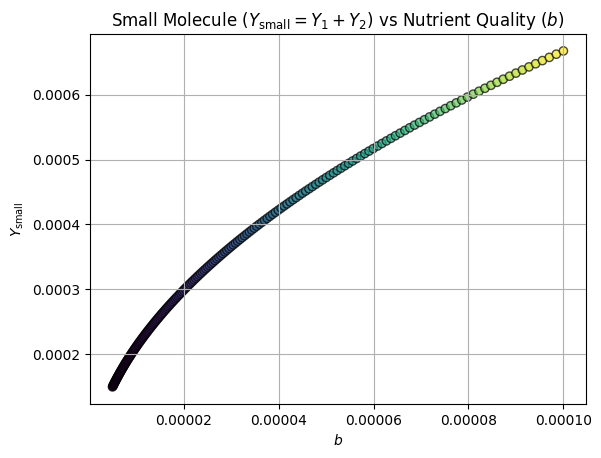

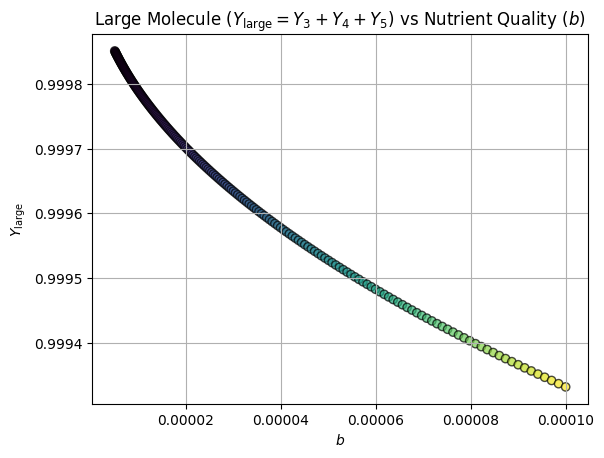

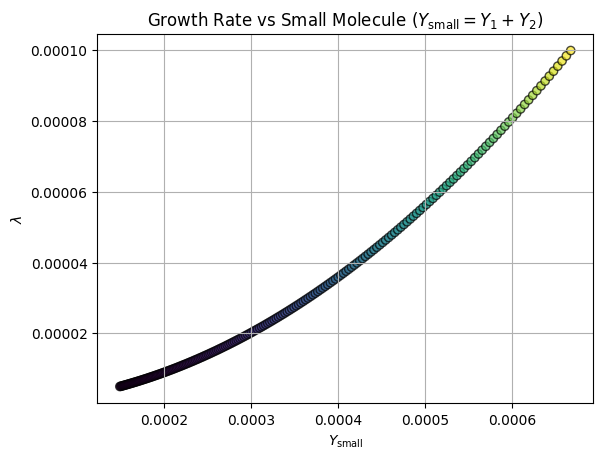

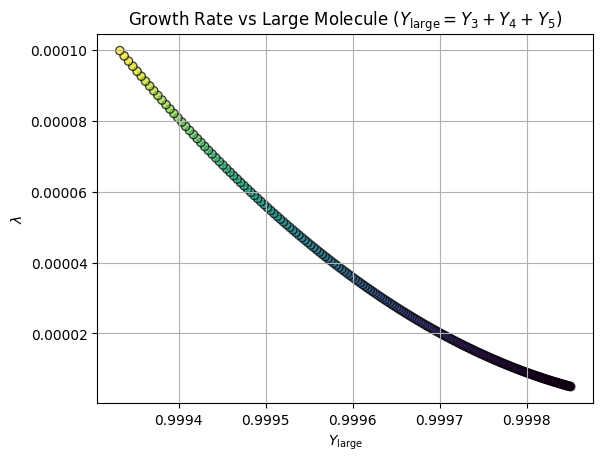

,Nutrient level,Growth rate,Small molecule fraction,Large molecule fraction
0,0.000005,0.000005,0.000149,0.999851
1,0.000005,0.000005,0.000150,0.999850
2,0.000005,0.000005,0.000152,0.999848
3,0.000005,0.000005,0.000153,0.999847
4,0.000005,0.000005,0.000154,0.999846
...,...,...,...,...
195,0.000094,0.000094,0.000648,0.999352
196,0.000096,0.000095,0.000653,0.999347
197,0.000097,0.000097,0.000657,0.999343
198,0.000099,0.000098,0.000662,0.999338


In [27]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr + Y2_arr
large_mol_arr = Y3_arr + Y4_arr + Y5_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
scatter = plt.scatter(b_arr, small_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small Molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(b_arr, large_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(small_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{small}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Small Molecule ($Y_\text{small} = Y_1 + Y_2$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(large_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{large}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Small molecule fraction": small_mol_arr,
    "Large molecule fraction": large_mol_arr,
})
display(df)

## Artificial Cell
Here we discuss what happens if the proteome partition is not optimal, but artificially setting the partition strength to fixed values. 

C:\Users\huang\AppData\Local\Temp\ipykernel_3092\482818827.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))


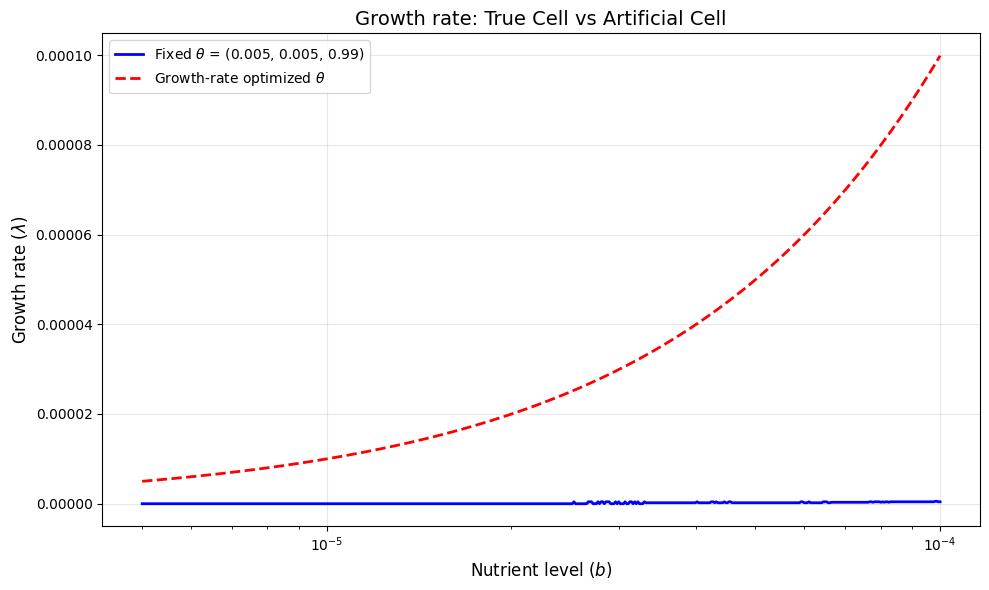

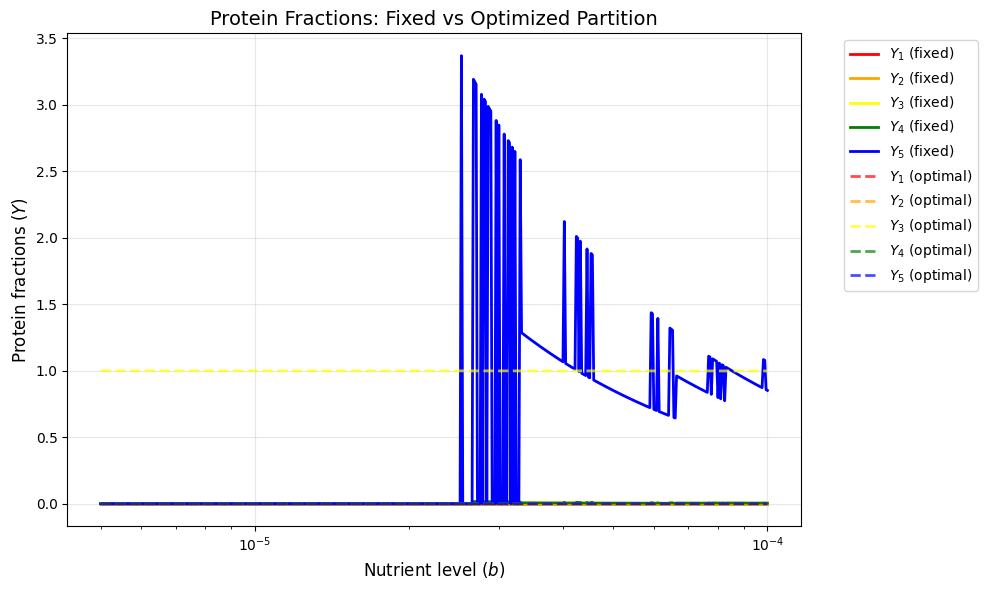

,b,lambda,Y1,Y2,Y3,Y4,Y5,Sum_Y
0,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
1,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
2,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
3,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
4,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
5,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
6,0.000005,0.0,1.862645e-09,0.0,0.0,0.0,0.0,1.862645e-09
7,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
8,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09
9,0.000005,0.0,2.328306e-09,0.0,0.0,0.0,0.0,2.328306e-09


In [33]:
# Fixed theta values (must sum to 1)
# theta1_fixed, theta2_fixed = 0.990, 0.005
# theta1_fixed, theta2_fixed = 0.005, 0.990
theta1_fixed, theta2_fixed = 0.005, 0.005
theta3_fixed = 1 - theta1_fixed - theta2_fixed

b_fixed_theta = np.logspace(np.log10(b_min), np.log10(b_max), 500)

# Calculate Y and lambda for each b with fixed theta
results_fixed = []
for b in b_fixed_theta:
    result = BioSystemMM3([theta1_fixed, theta2_fixed, theta3_fixed], b)
    results_fixed.append(result)

results_fixed = np.array(results_fixed)

(b_fixed, _, _, _, Y1_fixed, Y2_fixed, Y3_fixed, Y4_fixed, Y5_fixed, 
 lambda_fixed, r_avg_fixed) = results_fixed.T

# Plot growth rate vs b for fixed theta
plt.figure(figsize=(10, 6))
plt.plot(b_fixed, lambda_fixed, lw=2, color='blue', label=f'Fixed $\\theta$ = ({theta1_fixed}, {theta2_fixed}, {theta3_fixed})')
plt.plot(b_arr, lambda_arr, lw=2, color='red', linestyle='--', label='Growth-rate optimized $\\theta$')
plt.xlabel(r'Nutrient level ($b$)', fontsize=12)
plt.ylabel(r'Growth rate ($\lambda$)', fontsize=12)
plt.title(f'Growth rate: True Cell vs Artificial Cell', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Y values vs b
plt.figure(figsize=(10, 6))
plt.plot(b_fixed, Y1_fixed, lw=2, label='$Y_1$ (fixed)', color='red', linestyle='-')
plt.plot(b_fixed, Y2_fixed, lw=2, label='$Y_2$ (fixed)', color='orange', linestyle='-')
plt.plot(b_fixed, Y3_fixed, lw=2, label='$Y_3$ (fixed)', color='yellow', linestyle='-')
plt.plot(b_fixed, Y4_fixed, lw=2, label='$Y_4$ (fixed)', color='green', linestyle='-')
plt.plot(b_fixed, Y5_fixed, lw=2, label='$Y_5$ (fixed)', color='blue', linestyle='-')

# Add optimized Y values
plt.plot(b_arr, Y1_arr, lw=2, label='$Y_1$ (optimal)', color='red', linestyle='--', alpha=0.7)
plt.plot(b_arr, Y2_arr, lw=2, label='$Y_2$ (optimal)', color='orange', linestyle='--', alpha=0.7)
plt.plot(b_arr, Y3_arr, lw=2, label='$Y_3$ (optimal)', color='yellow', linestyle='--', alpha=0.7)
plt.plot(b_arr, Y4_arr, lw=2, label='$Y_4$ (optimal)', color='green', linestyle='--', alpha=0.7)
plt.plot(b_arr, Y5_arr, lw=2, label='$Y_5$ (optimal)', color='blue', linestyle='--', alpha=0.7)

plt.xlabel(r'Nutrient level ($b$)', fontsize=12)
plt.ylabel(r'Protein fractions ($Y$)', fontsize=12)
plt.title(f'Protein Fractions: Fixed vs Optimized Partition', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display data
df_fixed = pd.DataFrame({
    'b': b_fixed,
    'lambda': lambda_fixed,
    'Y1': Y1_fixed,
    'Y2': Y2_fixed,
    'Y3': Y3_fixed,
    'Y4': Y4_fixed,
    'Y5': Y5_fixed,
    'Sum_Y': Y1_fixed + Y2_fixed + Y3_fixed + Y4_fixed + Y5_fixed
})
display(df_fixed.head(10))

C:\Users\huang\AppData\Local\Temp\ipykernel_3092\482818827.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))


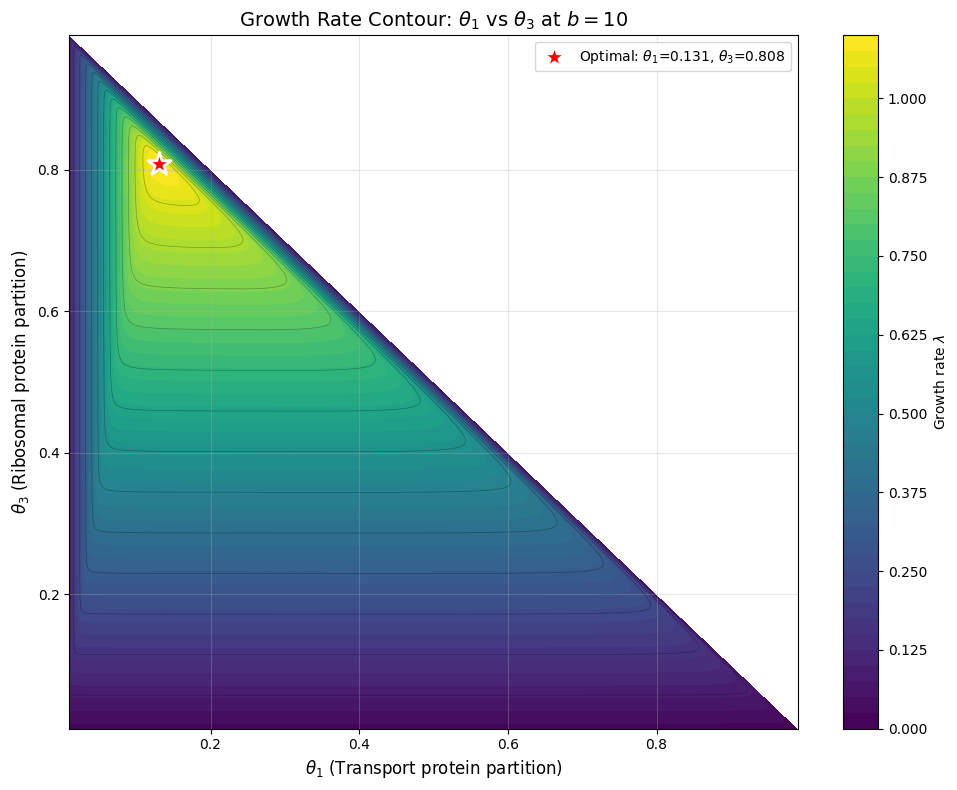

Optimal theta at b=10: theta1=0.1306, theta2=0.0610, theta3=0.8084
Maximum growth rate: lambda=1.0994


In [29]:
# Contour plot: Growth rate as function of theta2 and theta3 at fixed b
b_contour = 10

# Create grid for theta2 and theta3
theta1_vals = np.linspace(0.01, 0.99, 500)
theta3_vals = np.linspace(0.01, 0.99, 500)
Theta1, Theta3 = np.meshgrid(theta1_vals, theta3_vals)

# Calculate lambda for each (theta2, theta3) pair
Lambda_contour = np.empty_like(Theta1)

for i in range(Theta1.shape[0]):
    for j in range(Theta1.shape[1]):
        theta1 = Theta1[i, j]
        theta3 = Theta3[i, j]
        theta2 = 1 - theta1 - theta3  # theta2 determined by normalization

        # Only calculate if theta2 is valid (positive)
        if theta2 > 0:
            result = BioSystemMM3([theta1, theta2, theta3], b_contour)
            Lambda_contour[i, j] = result[9]  # lambda is at index 9
        else:
            Lambda_contour[i, j] = np.nan  # Invalid region

# Plot contour
plt.figure(figsize=(10, 8))
contour = plt.contourf(Theta1, Theta3, Lambda_contour, levels=50, cmap='viridis')
plt.colorbar(contour, label=r'Growth rate $\lambda$')

# Add contour lines
plt.contour(Theta1, Theta3, Lambda_contour, levels=15, colors='black', alpha=0.3, linewidths=0.5)

# Mark the optimized point
# Find optimal theta2 and theta3 at this b value
opt_result_contour = minimize(lambda u: objective_softmax(u, b_contour), [0.0, 0.0], method='Powell')
if opt_result_contour.success:
    theta1_opt_c, theta2_opt_c, theta3_opt_c = softmax_partition(opt_result_contour.x)
    plt.scatter(theta1_opt_c, theta3_opt_c, color='red', marker='*', s=300, 
                edgecolors='white', linewidths=2, label=f'Optimal: $\\theta_1$={theta1_opt_c:.3f}, $\\theta_3$={theta3_opt_c:.3f}', zorder=5)

plt.xlabel(r'$\theta_1$ (Transport protein partition)', fontsize=12)
plt.ylabel(r'$\theta_3$ (Ribosomal protein partition)', fontsize=12)
plt.title(f'Growth Rate Contour: $\\theta_1$ vs $\\theta_3$ at $b = {b_contour}$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"Optimal theta at b={b_contour}: theta1={theta1_opt_c:.4f}, theta2={theta2_opt_c:.4f}, theta3={theta3_opt_c:.4f}")
print(f"Maximum growth rate: lambda={-objective_softmax(opt_result_contour.x, b_contour):.4f}")

## Heat Map

<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
C:\Users\huang\AppData\Local\Temp\ipykernel_3092\2682396739.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}')


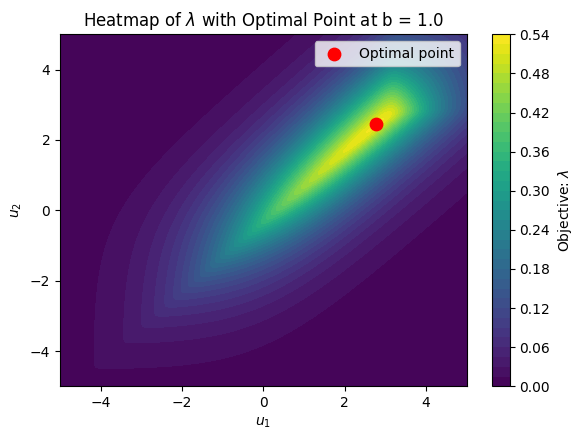

In [ ]:
b_target = 1.0

opt_result = minimize(lambda u: objective_softmax(u, b_target), [0.0, 0.0], method='BFGS')

if opt_result.success:
    u1_opt, u2_opt = opt_result.x
    lambda_opt = -objective_softmax([u1_opt, u2_opt], b_target)
    theta1_opt, theta2_opt, theta3_opt = softmax_partition([u1_opt, u2_opt])
else:
    u1_opt = u2_opt = lambda_opt = theta1_opt = theta2_opt = theta3_opt = np.nan

# grid
u1_vals = np.linspace(-5, 5, 1000)
u2_vals = np.linspace(-5, 5, 1000)
U1, U2 = np.meshgrid(u1_vals, u2_vals)
Z = np.empty_like(U1)

# lambda value
for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        Z[i, j] = - objective_softmax([U1[i, j], U2[i, j]], b_target)

# Plot
plt.figure(figsize=(6,4.5))
cp = plt.contourf(U1, U2, Z, levels=50, cmap='viridis')
plt.colorbar(cp, label=r'Objective: $\lambda$')

# Add contour lines
plt.contour(U1, U2, Z, levels=15, colors='black', alpha=0.3, linewidths=0.5)

# Mark optimal point with star
plt.scatter(u1_opt, u2_opt, color='red', marker='*', s=300, 
            edgecolors='white', linewidths=2, label='Optimal point', zorder=5)

plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.legend()
plt.tight_layout()
plt.show()